In [ ]:
!pip install wordcloud tensorflow
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("train.csv", names=["label","title","description"], skiprows=1)
df.head()

Saving train.csv to train (1).csv


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
def preprocess_lemma(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

df['clean_text'] = (df['title'] + " " + df['description']).apply(preprocess_lemma)


In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
df = df[df['label'] != 'Class Index'].copy()
df['label'] = pd.to_numeric(df['label']) # Convert label to numeric
df['clean_text'] = (df['title'] + " " + df['description']).apply(preprocess_lemma) # Create clean_text after filtering
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))


=== Logistic Regression ===
              precision    recall  f1-score   support

           1       0.93      0.90      0.91      6000
           2       0.95      0.98      0.97      6000
           3       0.89      0.89      0.89      6000
           4       0.90      0.90      0.90      6000

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.92     24000

=== Naive Bayes ===
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      6000
           2       0.95      0.98      0.96      6000
           3       0.88      0.87      0.87      6000
           4       0.88      0.88      0.88      6000

    accuracy                           0.91     24000
   macro avg       0.90      0.91      0.91     24000
weighted avg       0.90      0.91      0.91     24000



/tmp/ipython-input-3738126746.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


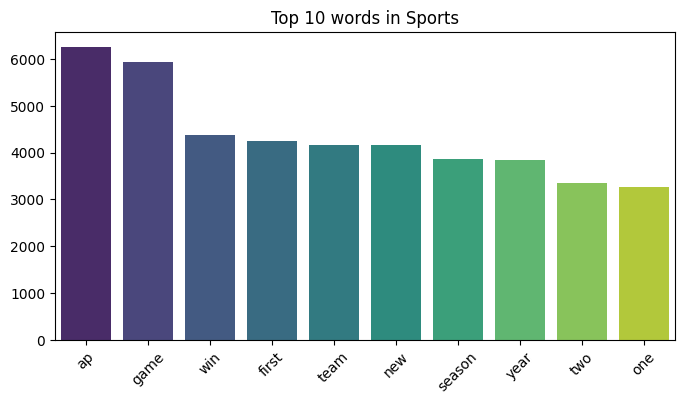

In [ ]:
from collections import Counter

def plot_top_words(category_id, top_n=10):
    text = " ".join(df[df['label']==category_id]['clean_text'])
    words = text.split()
    common_words = Counter(words).most_common(top_n)

    words, counts = zip(*common_words)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(words), y=list(counts), palette="viridis")
    plt.title(f"Top {top_n} words in { {1:'World',2:'Sports',3:'Business',4:'Sci/Tech'}[category_id] }")
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(2)  # Sports


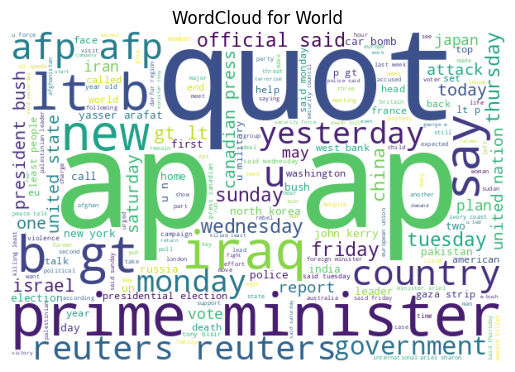

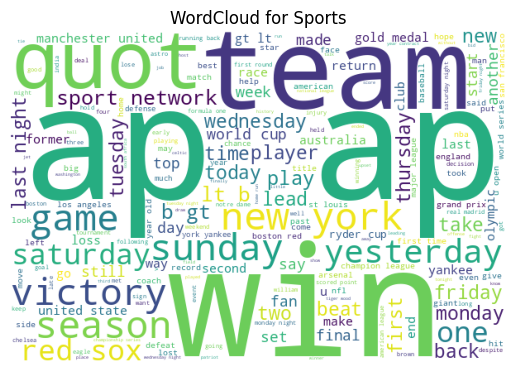

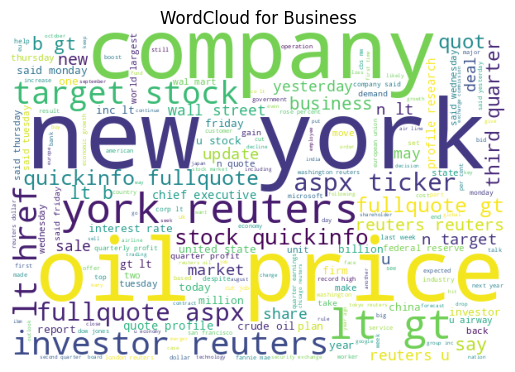

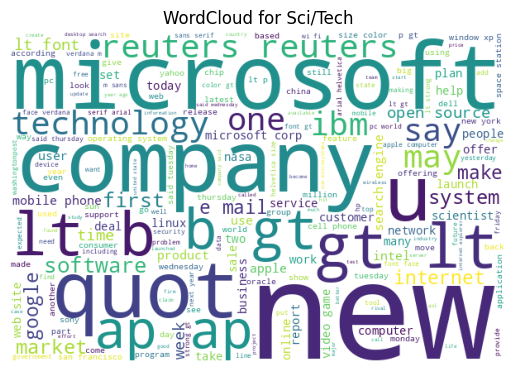

In [ ]:
for cat in [1,2,3,4]:
    text = " ".join(df[df['label']==cat]['clean_text'])
    wc = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud for { {1:'World',2:'Sports',3:'Business',4:'Sci/Tech'}[cat] }")
    plt.show()


In [ ]:
num_classes = len(set(y))

nn_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

nn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history = nn_model.fit(X_train, y_train - 1,
                       validation_split=0.1,
                       epochs=5,
                       batch_size=256,
                       verbose=1)

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8233 - loss: 0.7951 - val_accuracy: 0.9132 - val_loss: 0.2826
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9234 - loss: 0.2431 - val_accuracy: 0.9154 - val_loss: 0.2589
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9375 - loss: 0.1931 - val_accuracy: 0.9141 - val_loss: 0.2560
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9455 - loss: 0.1663 - val_accuracy: 0.9129 - val_loss: 0.2621
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9518 - loss: 0.1426 - val_accuracy: 0.9116 - val_loss: 0.2726


In [ ]:
test_loss, test_acc = nn_model.evaluate(X_test, y_test - 1, verbose=0) # Subtract 1 from y_test
print(f"Neural Network Accuracy: {test_acc:.4f}")

Neural Network Accuracy: 0.9149


In [ ]:
sample_news = [
    "Apple releases new iPhone with AI-powered features",
    "Stock markets fall as inflation fears grow",
    "The football team won the championship after a close match",
    "UN holds emergency meeting over global crisis"
]

sample_clean = [preprocess_lemma(r) for r in sample_news]
sample_vec = vectorizer.transform(sample_clean).toarray()

nn_preds = nn_model.predict(sample_vec)

for text, p in zip(sample_news, nn_preds):
    category = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}[p.argmax()+1]
    print(f"[{category}] -> {text}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[Sci/Tech] -> Apple releases new iPhone with AI-powered features
[Business] -> Stock markets fall as inflation fears grow
[Sports] -> The football team won the championship after a close match
[World] -> UN holds emergency meeting over global crisis
